In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Let's look at the 12th page of [article](https://www.researchgate.net/profile/Chong-Yung-Chi/publication/251134144_A_Convex_Analysis_Framework_for_Blind_Separation_of_NonNegative_Sources/links/5a1e7622aca272cbfbc04995/A-Convex-Analysis-Framework-for-Blind-Separation-of-NonNegative-Sources.pdf?_sg%5B0%5D=OMb8GSQ1miraTnwj9MuTl_sWqMTmx1MXLO3B6zfVi4OFqD1thTV7qA1ojzXKQSucagGKOYVy8QmNQOoE5oLX7Q.HcFDAcJ9Gd4ltbvqp_7ndt1Yhg35PL0PJa3iOnYJcpBA3OIiuYwL72YJ6ry46Cb_NEHNsAZBgi3jpf8EMTzYEg.b9vSGHXLraOewNOZkrAVlPI3Gdpmzc9JO-KbP2hbAA1PmpKU1T0TtgFylKVSCgVhmm7gCmd1kar37FwL4MKtKQ&_sg%5B1%5D=WIdyA5iABGfzLmDfwEfigkwWoN-Ahwrw8Z3t4D_7wZLt5iAIKaiCWZQYsLGAFMr59D7yASkWgn4KQy0-4-DErwnDWhtnvybd10KIsKCKc3BT.HcFDAcJ9Gd4ltbvqp_7ndt1Yhg35PL0PJa3iOnYJcpBA3OIiuYwL72YJ6ry46Cb_NEHNsAZBgi3jpf8EMTzYEg.b9vSGHXLraOewNOZkrAVlPI3Gdpmzc9JO-KbP2hbAA1PmpKU1T0TtgFylKVSCgVhmm7gCmd1kar37FwL4MKtKQ&_iepl=). There we will se CAMNS-LP method. Restore it step by step in python:

In [1]:
def CAMNS_LP(C, d, L):
    
    l = 0
    B = np.eye(L)
    
    while True:
    
        w = scp.stats.norm().rvs(L)        
        r = np.matmul(B, w)
        
        def fun(a):
            return np.matmul(r.T, (np.matmul(C, a) + d.flatten()))
        
        def rev_fun(a):
            return -(np.matmul(r.T, (np.matmul(C, a) + d.flatten())))
        
        constraint = scp.optimize.LinearConstraint(C, lb=-d.flatten(), ub=np.ones(C.shape[0]) * np.inf)

        a1 = scp.optimize.minimize(fun, 
                                   x0=np.array([0., 0.]),
                                   method='COBYLA',
                                   constraints=constraint).x

        a2 = scp.optimize.minimize(rev_fun, 
                                   x0=np.array([0., 0.]),
                                   method='COBYLA',
                                   constraints=constraint).x
        
        p = fun(a1)
        q = fun(a2)
        
        if l == 0:
            S = np.vstack((np.matmul(C, a1) + d.T, np.matmul(C, a2) + d.T)).T
        else:
            if abs(p) != 0:
                column = np.matmul(C, a1) + d.T
                S = np.hstack((S, column.reshape(-1, 1)))
            elif abs(q) != 0:
                column = np.matmul(C, a2) + d.T
                S = np.hstack((S, column.reshape(-1, 1)))

        l = S.shape[1]

        Q1, R1 = np.linalg.qr(S)
        B = np.eye(L) - np.matmul(Q1, Q1.T)
        
        if l == 3:
            break
    
    return S
    

Then at the 8th page we can see how to get matrix $C$ and column $d$. Let's restore it too:

In [3]:
def proposition_1(X):
    d = X.mean(axis=1).reshape(-1, 1)
    U = X - np.tile(d, (1, X.shape[1]))
    C = U[:, :2]
    return C, d

Our main function consists of two previously written:

In [4]:
def repair(images):
    C, d = proposition_1(images)
    return CAMNS_LP(C, d, images.shape[0])

Then we need some function to illustrate result and input pictures:

In [5]:
def draw_images(images, shape=(128, 128)):
    plt.figure(figsize=(20, 15))
    
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[:, i].reshape(shape) / 255, cmap='gray')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

    plt.show()

The following function will help you to make you image smaller (otherwise you will need a $9999999999$Gb ща RAM):

In [13]:
def resize_image(name, shape=(128, 128)):
    original_image = Image.open(name)
    width, height = original_image.size

    resized_image = original_image.resize(shape)
    width, height = resized_image.size

    resized_image.save(name)

Now let's test, what we have coded:

- make array with images
- mix them with some weights
- show to verify correctness
- use `repair` function
- look at the result
- **admire**

In [322]:
images = ['cao1.jpg', 'ksiwek1.jpg', 'zhang1.jpg']
flatten_images = np.array([plt.imread(i).flatten() for i in images])

weights = np.array([
    [0.5, 0.2, 0.3],
    [0.3, 0.6, 0.1],
    [0.1, 0.2, 0.7]
])

mixxed_images = np.matmul(flatten_images.T, weights)

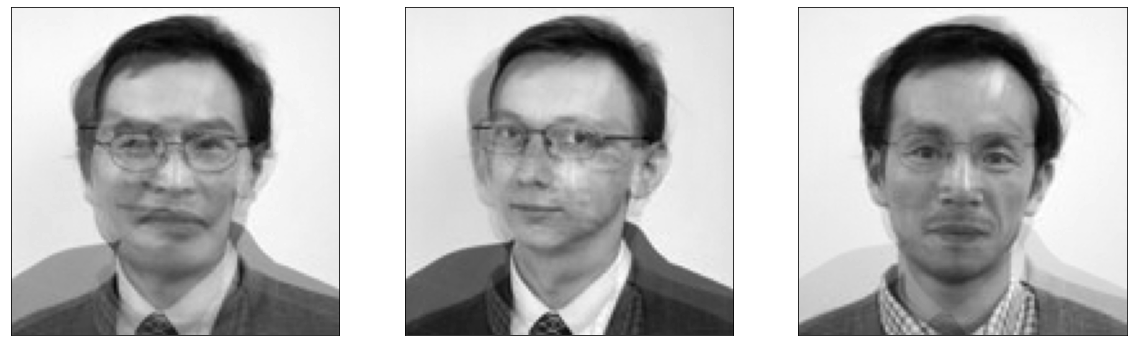

In [323]:
draw_images(mixxed_images)

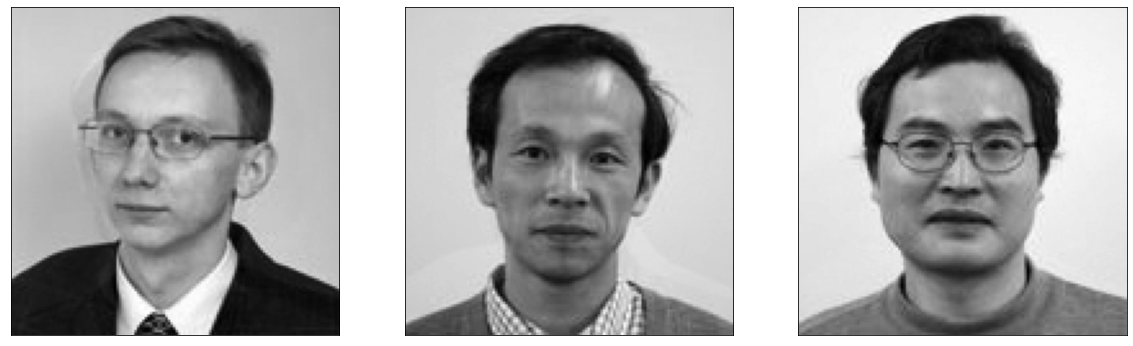

In [144]:
draw_images(repair(mixxed_images))

After *prolonged* admiration let's test how it will work with at first glance, the same, mandarines:
(they were too high-quality, so I had to ~~eat~~ resize them)

In [52]:
images = ['GREEN_mandarine.jpg', 'BIG_mandarine.jpg', 'ROUND_mandarine.jpg']
for i in images:
    resize_image(i, (90, 90))

flatten_images = np.array([plt.imread(i).flatten() for i in images])

weights = np.array([
    [0.5, 0.2, 0.3],
    [0.3, 0.6, 0.1],
    [0.1, 0.2, 0.7]
])

mixxed_images = np.matmul(flatten_images.T, weights)

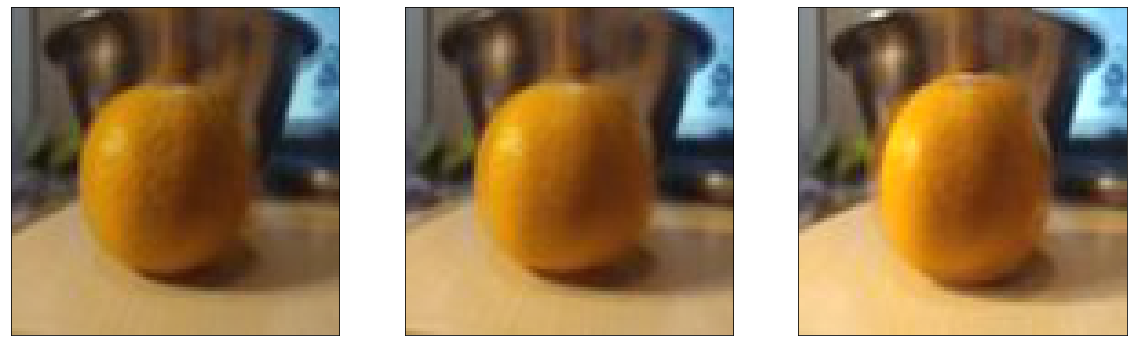

In [53]:
draw_images(mixxed_images, plt.imread('GREEN_mandarine.jpg').shape)

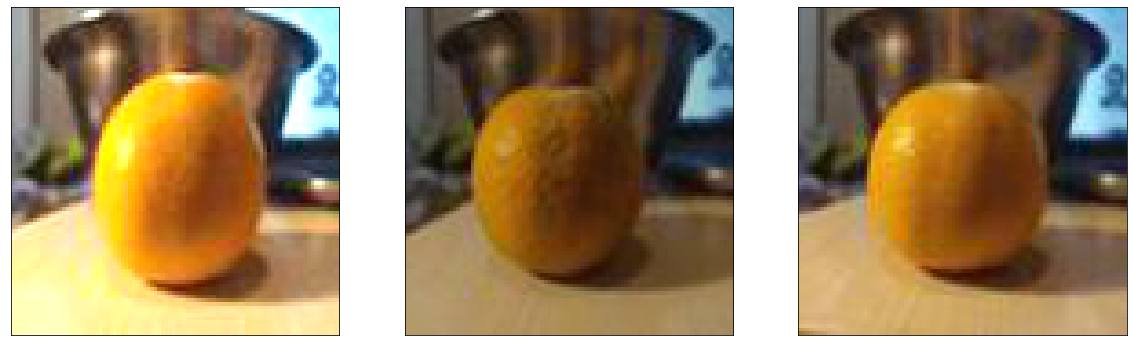

In [54]:
draw_images(repair(mixxed_images), plt.imread('GREEN_mandarine.jpg').shape)

***WOW!1!!*** Now we can see <span style="color:green">*GREEN*</span> mandarin, <font size="5"> **BIG** </font> one and &#127818; (round)